In [17]:
import pandas as pd
import sqlite3
import datetime
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

## Connect to DB, load data and convert to dataframe

In [2]:
db_path = "data/twitter_data.db"

In [3]:
conn = sqlite3.connect(db_path)
c = conn.cursor()

In [4]:
c.execute('SELECT SQLITE_VERSION()')

In [5]:
c.execute('SELECT * FROM tweets')
raw_data = c.fetchall()

In [6]:
conn.close()

In [7]:
raw_df = pd.DataFrame(raw_data)
raw_df.columns = ['text', 'username', 'date', 'location']

### Clean Twitter data

In [8]:
raw_df['date'] = pd.to_datetime(raw_df['date'])

In [9]:
import re

def tweet_cleaner(s):    
    s = re.sub(r"http\S+", "", s)
    s = s.replace("’", "'")
    #s = s.replace("'", "")
    s = s.replace("amp", "")
    #s = re.sub(r"\s*[^A-Za-z]+\s*", " ", s)
    #s = s.lower()
    return s

testing = raw_df.text[:]
test_result = []
for t in testing:
    test_result.append(tweet_cleaner(t))

In [10]:
# Combine into dataframe
test = pd.DataFrame(test_result)
test.columns = ['text']
clean_df = pd.concat([test, raw_df['date'], raw_df['location']], axis=1)
clean_df = clean_df[clean_df.text.str.contains('lebron')]
clean_df = clean_df.reset_index(drop=True)

### Tweets per minute

In [11]:
# time of tweet #edate = datetime.datetime(2018,7,1,23,0,0)

sdate = datetime.datetime(2018,6,30,23,0,0)
edate = datetime.datetime(2018,7,2,23,0,0)
date_df = []
date_df.append(sdate)

date = sdate
while date < edate:
    date += datetime.timedelta(minutes=1)
    date_df.append(date)

In [12]:
tweet_count = []
tweet_date = []
for i in range(0,len(date_df)-1):
    mask = (clean_df['date'] <= date_df[i+1]) & (clean_df['date'] > date_df[i])
    tweet_count.append(len(clean_df.loc[mask]))
    tweet_date.append(date_df[i])
tweet_count.append(0)

In [14]:
x = range(0,len(tweet_count))
xtickrange=np.arange(min(x), max(x), 500)
dtick=['']
for pos,tick in enumerate(xtickrange):
    dtick.append(str(tweet_date[tick]))
dtick.append(str((tweet_date[500]-tweet_date[0])+tweet_date[tick]))

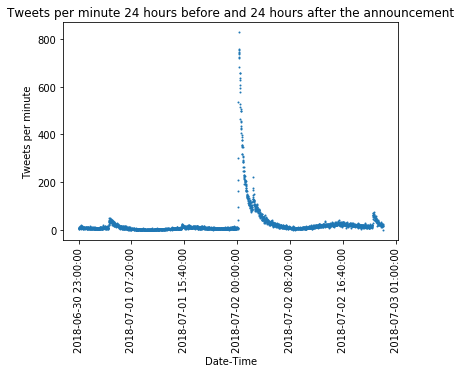

In [16]:
fig, ax = plt.subplots()
fig.canvas.draw()
plt.scatter(x, tweet_count,s=1)
ax.set_xticklabels(dtick)
plt.xticks(rotation=90)
ax.set_xlabel('Date-Time')
ax.set_ylabel('Tweets per minute')
plt.title('Tweets per minute 24 hours before and 24 hours after the announcement')
plt.show()

The scatter graph above presents the number of tweets published per minute that mention 'LeBron'. The data **excludes** retweets and favourites, only tweets explicitly written by users are considered. The date range of the graph is 24 hours before and 24 hours after the annoucement of LeBron's free-agent status. The rate of Tweets per minute (TPM) clearly spikes to a maximum of 829TPM around the time the announcement was made.

### Word cloud

In [ ]:
sdate = datetime.datetime(2018,6,30,23,0,0)
edate = datetime.datetime(2018,7,2,23,0,0)

In [27]:
mask = (clean_df['date'] > sdate) & (clean_df['date'] <= edate)
clean_df.loc[mask]
sub_df = clean_df.loc[mask]

In [30]:
single_text=sub_df['text'].str.cat(sep=', ')

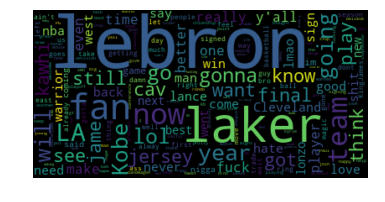

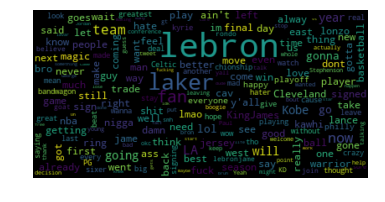

In [34]:
text=clean_df['text']
wordcloud = WordCloud(collocations=False).generate(single_text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(collocations=False,max_font_size=40).generate(single_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# The pil way (if you don't have matplotlib)
# image = wordcloud.to_image()
#image.show()